In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

## Image feature extraction and comparison
Yixuan Wang 530634085
#### Proble: simple grayscale thresholding cannot be applied to real-world image with various backgrounds.
#### This note book aims to denoise hand images to naive binary images
#### Techniques used in this work: hsv conversion, Ycbcr conversion, Ostu thresholding, adaptive thresholding
#### In general, cb/cr has good performance in image denoising and  edge detecting.Otsu thresholding effectively transforms the image into the binary format. This combination can be considered as a potential solution in this project
#### After this step, we will start process the binary image, extract contours and conduct calculations.

### 14/09 update
Multi OTSU applied. It expectes to reduce the sencitivity to some colors and improve robustness.

An opening operation applied to remove small connections
 


In [4]:
path = "images/image.png"
# path = "images/test1.jpg"
img=cv2.imread(path)


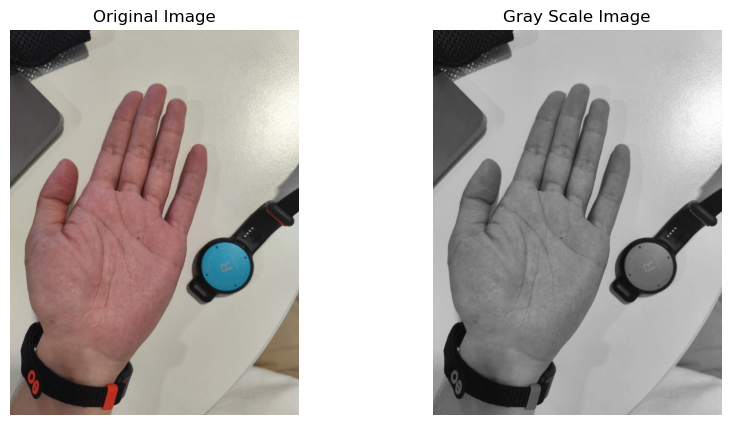

In [5]:
gray_scale=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(gray_scale, cmap="gray")
ax[1].set_title("Gray Scale Image")
ax[1].axis("off")
plt.show()

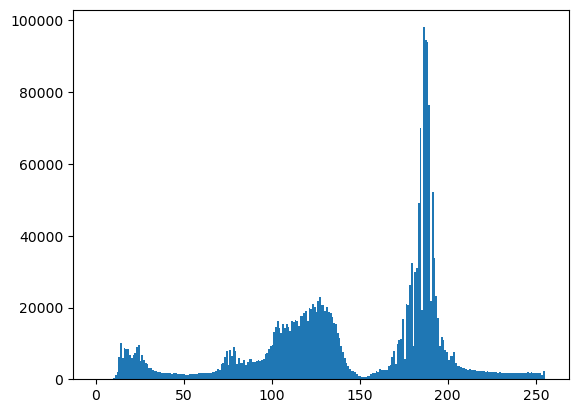

In [6]:
# show the histogram of the gray scale image
plt.hist(gray_scale.ravel(), 256, [0, 256])
plt.show()

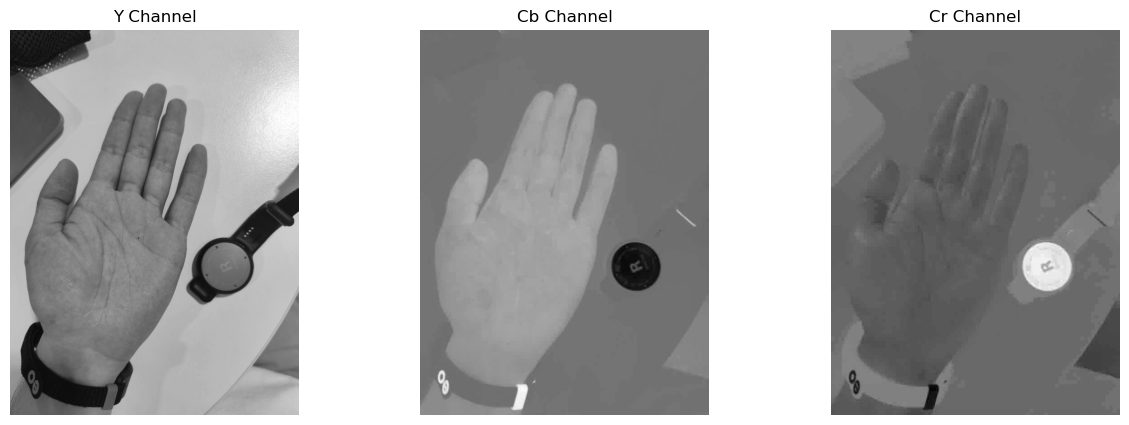

In [7]:
# YCbCr color space，display the Y, Cb, Cr channels
ycbcr=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ycbcr[:,:,0], cmap="gray")
ax[0].set_title("Y Channel")
ax[0].axis("off")

ax[1].imshow(ycbcr[:,:,1], cmap="gray")
ax[1].set_title("Cb Channel")
ax[1].axis("off")

ax[2].imshow(ycbcr[:,:,2], cmap="gray")
ax[2].set_title("Cr Channel")
ax[2].axis("off")

plt.show()

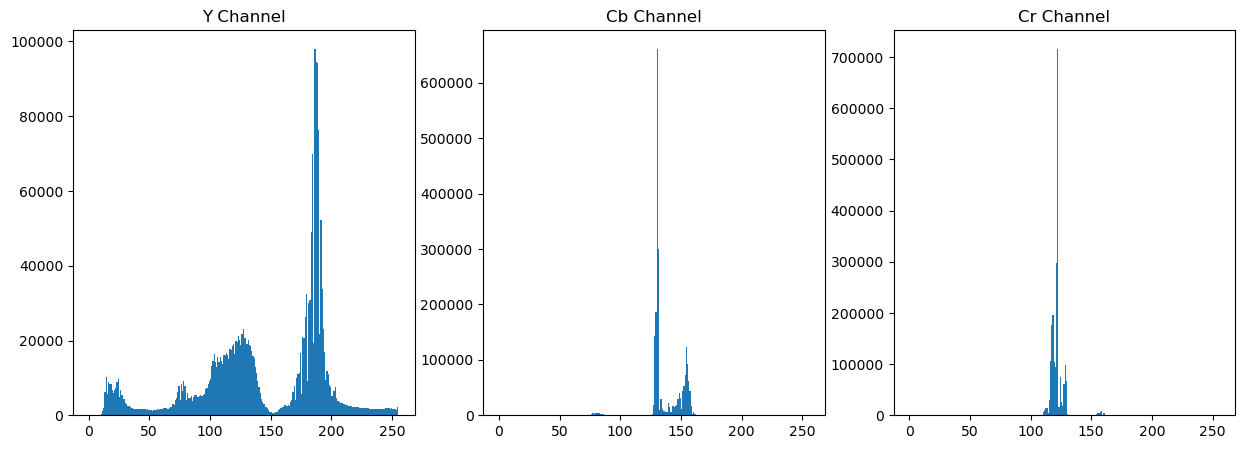

In [8]:
# display the three histogram of the ycbcr image
y, cb, cr = cv2.split(ycbcr)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(y.ravel(), 256, [0, 256])
ax[0].set_title("Y Channel")
ax[1].hist(cb.ravel(), 256, [0, 256])
ax[1].set_title("Cb Channel")
ax[2].hist(cr.ravel(), 256, [0, 256])
ax[2].set_title("Cr Channel")
plt.show()

## Multi OTSU thresholding - roughly equals a k=3 kMeans clusering

- three sections(reference, palm and background) are extracted instead of two(fore scene and the background)

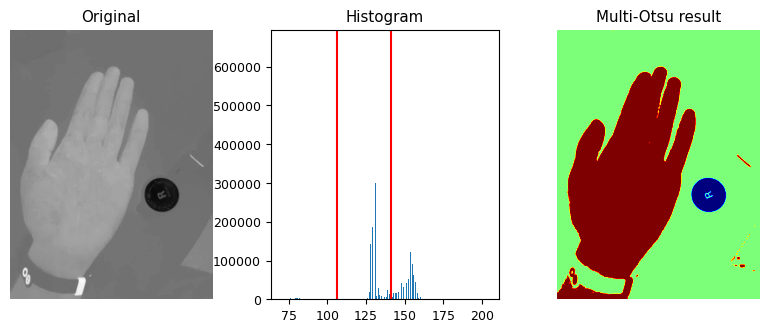

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = cb

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

### #binary otsu thresholding - cannot sense the blue color


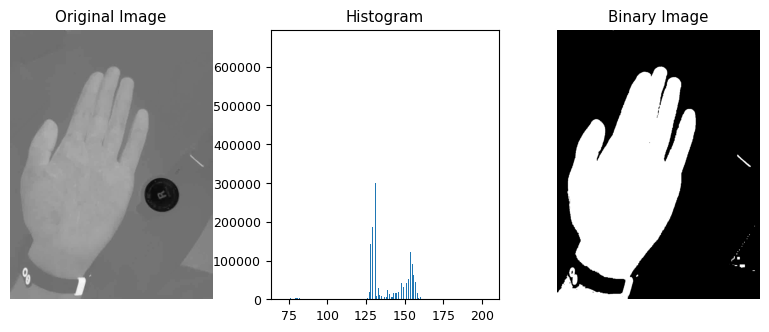

In [10]:
#binary otsu thresholding - cannot sense the blue color
ret,thresh1 = cv2.threshold(cb,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ax, fig = plt.subplots(1, 3, figsize=(10, 3.5))
fig[0].imshow(cb, cmap="gray")
fig[0].set_title("Original Image")
fig[0].axis("off")
# histogram of the original image
fig[1].hist(image.ravel(), bins=255)
fig[1].set_title('Histogram')
# binary image
fig[2].imshow(thresh1, cmap="gray")
fig[2].set_title("Binary Image")
fig[2].axis("off")
plt.show()


In [11]:
from imutils import grab_contours
import imutils

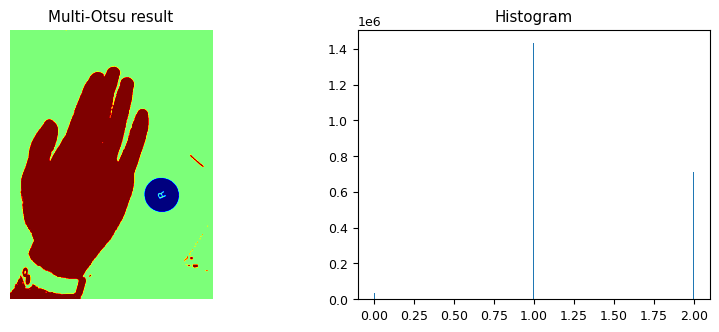

In [16]:
#the histogram of the regions_8uc1 
ax, fig = plt.subplots(1, 2, figsize=(10, 3.5))

fig[0].imshow(regions, cmap='jet')
fig[0].set_title('Multi-Otsu result')
fig[0].axis('off')
fig[1].hist(regions_8uc1.ravel(), bins=255)
fig[1].set_title('Histogram')
# binary image
plt.show()

In [13]:
def is_circle(contour, epsilon=0.2):
    area = cv2.contourArea(contour)
    if area == 0:
        return False
    ((x, y), radius) = cv2.minEnclosingCircle(contour)
    circle_area = np.pi * (radius ** 2)
    print(f"Area: {area}, Circle Area: {circle_area}")
    return abs(area - circle_area) / circle_area < epsilon


### open operation - remove the samll connection between the palm and the forearm

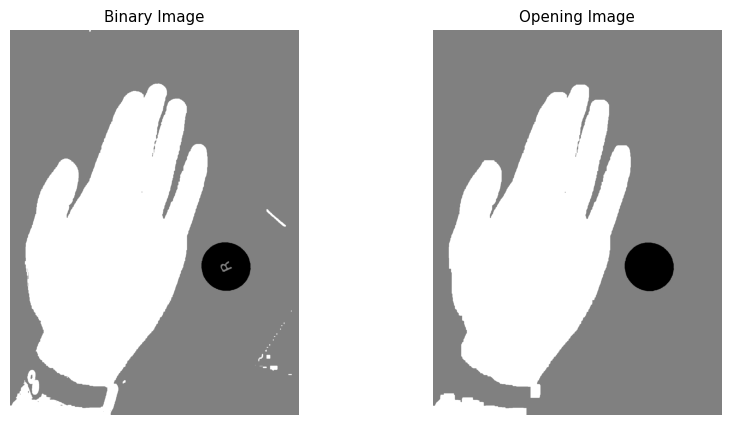

In [14]:
#opening operation on the threshold image
def opening(image, kernel_size=40):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(regions_8uc1, cmap="gray")
ax[0].set_title("Binary Image")
ax[0].axis("off")

thresh1_opening = opening(regions_8uc1)
ax[1].imshow(thresh1_opening, cmap="gray")
ax[1].set_title("Opening Image")
ax[1].axis("off")
plt.show()

### length estimate -- not implemented yet

1. find the object center
2. find the longest line going through the object center within the contour, use this line as the palm length

The length of the longest line is: 2131.400009383504
The length of the longest line is: 2131.400009383504


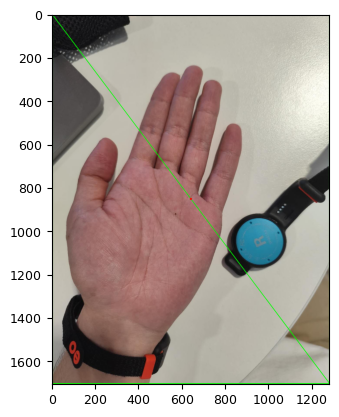

In [75]:
def calculate_center(contour):
    M = cv2.moments(contour)
    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        center_x, center_y = 0, 0
    return center_x, center_y

def find_longest_line_passing_center(contour):
    center_x, center_y = calculate_center(contour)
    max_length = 0
    longest_line = None
    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            pt1 = tuple(contour[i][0])
            pt2 = tuple(contour[j][0])
            # check if the line is horizontal or vertical
            if pt1[0] == pt2[0] or pt1[1] == pt2[1]:
                continue
            # check if the line passes the center
            if (pt1[0] - center_x) * (pt2[0] - center_x) < 0 or (pt1[1] - center_y) * (pt2[1] - center_y) < 0:                
                length = np.linalg.norm(np.array(pt1) - np.array(pt2))
                if length > max_length:
                    max_length = length
                    longest_line = (pt1, pt2)
    return longest_line, (center_x, center_y)

cnt_list=[hand,circle[0]]
length_list=[]
# Iterate through each contour
for contour in cnt_list:
    # Approximate the contour to a polygon
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # Find the longest line in the approximated polygon
    longest_line,center = find_longest_line_passing_center(approx)
    #print the length of the longest line
    print("The length of the longest line is: {}".format(np.linalg.norm(np.array(longest_line[0]) - np.array(longest_line[1]))))
    length_list.append(np.linalg.norm(np.array(longest_line[0]) - np.array(longest_line[1])))
    # Draw the longest line and the center on the image

    if longest_line is not None:
        cv2.line(img, longest_line[0], longest_line[1], (0, 255, 0), 2)
        cv2.circle(img, center, 5, (0, 0, 255), -1)

# Display the result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
